# SI 624 Final Project Code

### Part 1: Data and package imports

In [123]:
import os
from datetime import datetime
import imageio
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
from matplotlib import transforms
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from jenkspy import JenksNaturalBreaks
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from tqdm.notebook import tqdm

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [30]:
# social determinants of health
sdoh_df = pd.read_excel("./data/SDOH_2020_COUNTY_1_0.xlsx", sheet_name="Data")

# unemployment rate dataset
unemp_df = pd.read_excel(
    "./data/Unemployment.xlsx",
    sheet_name="UnemploymentMedianIncome",
    skiprows=[0, 1, 2, 3],
    header=None,
)
unemp_df = pd.DataFrame(unemp_df.values[1:], columns=unemp_df.iloc[0])

# poverty rate dataset
pov_df = pd.read_excel(
    "./data/PovertyEstimates.xlsx",
    sheet_name="PovertyEstimates",
    skiprows=[0, 1, 2, 3],
    header=None,
)
pov_df = pd.DataFrame(pov_df.values[1:], columns=pov_df.iloc[0])
pov_df['FIPS_Code'] = pov_df['FIPS_Code'].astype("float32")

# population estimate for 2020
pop_df = pd.read_excel(
    "./data/PopulationEstimates.xlsx",
    sheet_name="Population",
    skiprows=[0,1,2,3]
)

# geometry shape file - state level
sgdf = gpd.read_file("./data/cb_2022_us_state_500k/cb_2022_us_state_500k.shp")
sgdf = sgdf.drop(['ALAND', 'AWATER','GEOID', 'AFFGEOID', 'STATENS'], axis=1)


In [101]:
# opioid overdose death
death_df = pd.DataFrame()

for file in os.listdir("./data/WONDER"):
    if file[-3:] == "txt":
        temp = pd.read_csv(f"./data/WONDER/{file}", sep="\t")
        temp["year"] = int(file[-8:-4])
        # temp['Crude Rate'] = temp['Crude Rate'].replace("Unreliable", np.nan)
        temp.drop("Notes", axis=1, inplace=True)
        death_df = pd.concat([temp, death_df], axis=0)

death_df = (
    death_df.reset_index()
    .dropna(subset=["County", "County Code", "Deaths", "Population", "Crude Rate"])
    .drop("index", axis=1)
)

In [5]:
# Opioid dispensing rate 2006-2020
# set to True if we want to refresh CDC data source
REFRESH_OPIOID_SOURCE = False

if REFRESH_OPIOID_SOURCE:
    for i in range(2006, 2021):
        print(f"at: {i}")
        df = pd.read_html(
            f"https://www.cdc.gov/drugoverdose/rxrate-maps/county{i}.html"
        )[0]
        df["year"] = i
        df.to_csv(f"./data/opioid_rx/{i}.csv")

l = [
    pd.read_csv(f"./data/opioid_rx/{file}")
    for file in os.listdir("./data/opioid_rx")
    if file[-3:] == "csv"
]
df = pd.concat(l)

df["year"] = df["year"].fillna(2020)
df["Opioid Dispensing Rate per 100"] = (
    df["Opioid Dispensing Rate per 100"].replace("–", np.nan).astype("float32")
)
df["County FIPS Code"] = np.where(
    (df["year"] == 2020), df["State_County FIPS Code"], df["County FIPS Code"]
)

df = df.reset_index().drop(
    ["Unnamed: 0", "index", "State_County FIPS Code", "State FIPS code"], axis=1
)

df['Opioid Dispensing Rate per 100'] = df['Opioid Dispensing Rate per 100'].apply(lambda x: round(x, 2))

In [67]:
pov_no_state = pov_df[np.where(pov_df['FIPS_Code'] % 1000 == 0, False, True)].shape

death_df_exp = death_df.copy()
death_df_exp['Crude Rate'] = death_df_exp['Crude Rate'].replace("Unreliable", np.nan)
pd.DataFrame({"Opioid Dispensing Data, 2006-2020": [(df.isna().sum().sum() / (df.shape[0] * df.shape[1])) * 100], 
              "Opioid Overdose Death Rate Data": [(death_df_exp.isna().sum().sum() / (death_df_exp.shape[0] * death_df_exp.shape[1])) * 100],
              "Poverty Estimates for the U.S., States and Counties": [(pov_df[np.where(pov_df['FIPS_Code'] % 1000 == 0, False, True)].isna().sum().sum() / (pov_no_state[0] * pov_no_state[1])) * 100]}).T

,0
"Opioid Dispensing Data, 2006-2020",1.590641
Opioid Overdose Death Rate Data,7.073961
"Poverty Estimates for the U.S., States and Counties",17.683554


In [15]:
(
    df.isna()
    .sum()
    .reset_index()
    .merge(df.count().reset_index(), how="inner", on="index")
    .assign(missing_perc=lambda x: (x["0_x"] / x["0_y"]) * 100)
    .rename(columns={"0_x": "missing data",
                     '0_y': "total data count"})
)

,index,missing data,total data count,missing_perc
0,County,0,46585,0.000000
1,State,0,46585,0.000000
2,County FIPS Code,0,46585,0.000000
3,Opioid Dispensing Rate per 100,3705,42880,8.640392
4,year,0,46585,0.000000


In [18]:
(
    sdoh_df[
        [
            "YEAR",
            "COUNTYFIPS",
            "STATEFIPS",
            "STATE",
            "COUNTY",
            "AHRF_USDA_RUCC_2013",
            "AMFAR_MEDSAFAC_RATE",
            "AMFAR_MEDMHFAC_RATE",
            "SAIPE_MEDIAN_HH_INCOME",
            "ACS_GINI_INDEX",
            "SAIPE_PCT_POV",
        ]
    ].drop()
    .isna()
    .sum()
    .reset_index()
    .merge(sdoh_df.count().reset_index(), how="inner", on="index")
    .assign(missing_perc=lambda x: (x["0_x"] / x["0_y"]) * 100)
    .rename(columns={"0_x": "missing data", "0_y": "total data count"})
)

,index,missing data,total data count,missing_perc
0,YEAR,0,3229,0.000000
1,COUNTYFIPS,0,3229,0.000000
2,STATEFIPS,0,3229,0.000000
3,STATE,0,3229,0.000000
4,COUNTY,0,3229,0.000000
5,AHRF_USDA_RUCC_2013,9,3220,0.279503
6,AMFAR_MEDSAFAC_RATE,9,3220,0.279503
7,AMFAR_MEDMHFAC_RATE,9,3220,0.279503
8,SAIPE_MEDIAN_HH_INCOME,87,3142,2.768937
9,ACS_GINI_INDEX,8,3221,0.248370


We investigated the missing data that exist in the varialbe we used and discovered that the missing data points are for 

### Question 1:

In [4]:
(
    # get the county with highest opioid dispensing rate
    df.loc[df.groupby('year')['Opioid Dispensing Rate per 100']
    .idxmax()].query('year == 2020')
)

,County,State,County FIPS Code,Opioid Dispensing Rate per 100,year
6021,NORTON CITY,VA,51720.0,406.7,2020.0


In [13]:
(
    df.query("year == 2020")
    .groupby("State")["Opioid Dispensing Rate per 100"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
    .head(5)
)

,State,Opioid Dispensing Rate per 100
0,AL,56.913433
1,AR,56.773333
2,TN,53.225263
3,KY,52.556303
4,GA,45.888462


In [14]:
# TODO: Add death rate 

## Question 2

In [49]:
state_rx = df.groupby(['State', 'year'], as_index=False).agg({"Opioid Dispensing Rate per 100": "mean"})

jnb = JenksNaturalBreaks(5)
jnb.fit(state_rx['Opioid Dispensing Rate per 100'])

cls = []
for i in range(len(jnb.breaks_)):
     try: 
          a = str(round(jnb.breaks_[i], 1))
          b = str(round(jnb.breaks_[i+1], 1))
          cls.append(f"{a}-{b}")
     except:
          pass

state_rx['cls'] = state_rx['Opioid Dispensing Rate per 100'].apply(lambda x: "abcde"[jnb.predict(x)])
strx_gdf = sgdf[['STUSPS', 'geometry']].merge(state_rx, how="right", left_on="STUSPS", right_on="State")

In [52]:
# https://stackoverflow.com/questions/67575936/moving-alaska-and-hawaii-in-geopandas-for-choropleths
vmin = strx_gdf["Opioid Dispensing Rate per 100"].min()
vmax = strx_gdf["Opioid Dispensing Rate per 100"].max()

colmap = plt.cm.Reds

plot_color = [mcolors.to_hex(c) for c in colmap([0.2, 0.4, 0.6, 0.8, 1.0])]
color_dict = {i:c for i,c in zip("abcde", plot_color)}

plot_extra = True
for i in tqdm(range(2006, 2021)):
    # print(f"making {i} plot")
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))

    filtered_data = filtered_data = strx_gdf[~(strx_gdf["State"].isin(["AK", "HI"])) & (strx_gdf["year"] == i)].to_crs(epsg=2163)
    filtered_data.plot(
        column="cls",
        categorical=True,
        color = filtered_data["cls"].map(color_dict),
        legend=True,
        ax=ax,
        legend_kwds={"frameon": False, "labels": cls, 'loc':'lower right'},
        edgecolor="k",
    )

    legend_patches = [Patch(color=color_dict[cls], label=cls) for cls in color_dict.keys()]
    ax.legend(handles=legend_patches, frameon=False, loc='lower right', labels=cls)

    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"Opioid dispensing rate per 100 persons, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.2])
    strx_gdf[(strx_gdf["State"] == "AK") & (strx_gdf["year"] == i)].to_crs(
        epsg=3338
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_ak,
        edgecolor="k",
    )
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    ax_hi = fig.add_axes([0.59, 0.05, 0.2, 0.2])
    strx_gdf[(strx_gdf["State"] == "HI") & (strx_gdf["year"] == i)].to_crs(
        epsg=4326
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_hi,
        edgecolor="k",
    )
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        #
        ax_pp = fig.add_axes([1, 0.58, 0.3, 0.27])
        mean_df = (
            strx_gdf.groupby("year")["Opioid Dispensing Rate per 100"]
            .mean()
            .reset_index()
        )
        ax_pp.plot_date(
            pd.to_datetime(i, format="%Y"),
            [mean_df.loc[i - 2006]["Opioid Dispensing Rate per 100"]],
            "go",
        )
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        mean_df[["year", "Opioid Dispensing Rate per 100"]].plot(
            x="year", y="Opioid Dispensing Rate per 100", ax=ax_pp
        )
        ax_pp.set_title("Yearly trend of national mean dispensing rate")
        ax_pp.set_ylabel("Dispensing rate per 100 persons")
        ax_pp.annotate(
            f"{i} Mean: {str(round(mean_df.loc[i-2006]['Opioid Dispensing Rate per 100'], 1))}",
            xy=(pd.to_datetime(2007, format="%Y"), 45),
        )
        ax_pp.get_legend().remove()

        # histogram of dispensing rate of year
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        strx_gdf[strx_gdf["year"] == i]["Opioid Dispensing Rate per 100"].plot(
            kind="hist", ax=ax_hist, bins=15
        )
        ax_hist.set_title(f"Distribution of dispensing rate for {i}")
        ax_hist.set_xlim(0, vmax)
        ax_hist.set_ylim(0, 15)
        ax_hist.set_xlabel("Rate")

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./viz_raw/state_jnb/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

fname = "./visualization/2006-2020 state opioid dispensing rate.gif"

print("generating animation...")
with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in tqdm(sorted([f for f in os.listdir(os.curdir + "/viz_raw/state_jnb/") if os.path.isfile(os.curdir + "/viz_raw/state_jnb/" + f)])):
        image = imageio.imread("./viz_raw/state_jnb/" + filename)
        writer.append_data(image)

  0%|          | 0/15 [00:00<?, ?it/s]

generating animation...


  0%|          | 0/15 [00:00<?, ?it/s]

In [110]:
# opioid overdose death
death_df = pd.DataFrame()

for file in os.listdir("./data/WONDER"):
    if file[-3:] == "txt":
        temp = pd.read_csv(f"./data/WONDER/{file}", sep="\t")
        temp["year"] = int(file[-8:-4])
        temp.drop("Notes", axis=1, inplace=True)
        death_df = pd.concat([temp, death_df], axis=0)

death_df = (
    death_df.reset_index()
    .dropna(subset=["County", "County Code", "Deaths", "Population", "Crude Rate"])
    .drop("index", axis=1)
)

death_df['State'] = death_df['County'].apply(lambda x: x.split(', ')[1])
# create place holder column to avoid states getting wipped out by accident
death_df['Rate'] = (death_df['Deaths'] / death_df['Population']) * 100000
death_df = death_df.drop(death_df[death_df['Crude Rate'] == 'Unreliable'].index)
death_df['Crude Rate'] = death_df['Crude Rate'].astype("float32")

jnb = JenksNaturalBreaks(5)
jnb.fit(death_df['Crude Rate'])

# generate a list of strings for the break ranges
cls = []
for i in range(len(jnb.breaks_)):
     try: 
          a = str(round(jnb.breaks_[i], 1))
          b = str(round(jnb.breaks_[i+1], 1))
          cls.append(f"{a}-{b}")
     except:
          pass

death_df['cls'] = death_df['Crude Rate'].apply(lambda x: "abcde"[jnb.predict(x)])

In [112]:
# 1. Create a complete list of state-year combinations
all_states = sgdf["STUSPS"].unique()
all_years = death_df["year"].unique()

# Cartesian product of states and years
state_years = pd.MultiIndex.from_product(
    [all_states, all_years], names=["State", "year"]
).to_frame(index=False)

# 2. Merge this list with your data
augmented_death_df = state_years.merge(death_df, on=["State", "year"], how="left")
augmented_death_df['Crude Rate'] = augmented_death_df['Crude Rate'].fillna(1e-3)
augmented_death_df['cls'] = augmented_death_df['cls'].fillna("x")

death_sgdf = sgdf.merge(
    (augmented_death_df.groupby(["State", "cls", "year"])["Crude Rate"].mean().reset_index()),
    how="left",
    left_on="STUSPS",
    right_on="State",
)

# dropping US Territories and commonwealth areas 
death_sgdf = death_sgdf.drop(
    death_sgdf[
        death_sgdf["STUSPS"].isin(['AS', 'GU', 'MP', 'PR', 'VI', 'UM'])
    ].index
)

In [116]:
# https://stackoverflow.com/questions/67575936/moving-alaska-and-hawaii-in-geopandas-for-choropleths
vmin = death_sgdf["Crude Rate"].min()
vmax = death_sgdf["Crude Rate"].max()

colmap = plt.cm.Reds

plot_color = [mcolors.to_hex(c) for c in colmap([0.2, 0.4, 0.6, 0.8, 1.0])] + [
    "#CCCCCC"
]
color_dict = {i: c for i, c in zip(['a', 'b', 'c', 'd', 'e', 'x'], plot_color)}

plot_extra = True
for i in range(2006, 2021):
    print(f"making {i} plot")
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))

    filtered_data = death_sgdf[
        ~(death_sgdf["State"].isin(["AK", "HI"])) & (death_sgdf["year"] == i)
    ].to_crs(epsg=2163)
    filtered_data.plot(
        column="cls",
        categorical=True,
        color=filtered_data["cls"].map(color_dict),
        legend=True,
        ax=ax,
        legend_kwds={"frameon": False, "labels": cls, "loc": "lower right"},
        edgecolor="k",
    )

    legend_patches = [
        Patch(color=color_dict[cls], label=cls) for cls in ['a', 'b', 'c', 'd', 'e']
    ]
    legend_patches.append(Patch(color="#CCCCCC", label="No data"))
    ax.legend(handles=legend_patches, frameon=False, loc="lower right", labels=cls + ['No data'])

    ax.grid(False)
    ax.axis("off")
    ax.set_title(f"Opioid Overdose Death Crude Rates, {i}", fontdict={"fontsize": 25})
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.2])
    death_sgdf[(death_sgdf["State"] == "AK") & (death_sgdf["year"] == i)].to_crs(
        epsg=3338
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color=filtered_data["cls"].map(color_dict),
        ax=ax_ak,
        edgecolor="k",
    )
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    ax_hi = fig.add_axes([0.59, 0.05, 0.2, 0.2])
    death_sgdf[(death_sgdf["State"] == "HI") & (death_sgdf["year"] == i)].to_crs(
        epsg=4326
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color=filtered_data["cls"].map(color_dict),
        ax=ax_hi,
        edgecolor="k",
    )
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        #
        ax_pp = fig.add_axes([1, 0.58, 0.3, 0.27])
        mean_df = death_sgdf.groupby("year")["Crude Rate"].mean().reset_index()
        ax_pp.plot_date(
            pd.to_datetime(i, format="%Y"),
            [mean_df.loc[i - 2006]["Crude Rate"]],
            "go",
        )
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        mean_df[["year", "Crude Rate"]].plot(x="year", y="Crude Rate", ax=ax_pp)
        ax_pp.set_title("Yearly trend of\nnational mean opioid overdose death Crude Rate")
        ax_pp.set_ylabel("Crude death Crude Rate")
        ax_pp.annotate(
            f"{i} Mean: {str(round(mean_df.loc[i-2006]['Crude Rate'], 1))}",
            xy=(pd.to_datetime(2007, format="%Y"), 25),
        )
        ax_pp.set_ylim(0, 32)
        ax_pp.get_legend().remove()

        # histogram of death Crude Rate of year
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        death_sgdf[death_sgdf["year"] == i].groupby('State')["Crude Rate"].mean().plot(
            kind="hist", ax=ax_hist, bins=10
        )
        ax_hist.set_xlim(0, 159.6)
        ax_hist.set_ylim(0, 25)
        ax_hist.set_title(f"Distribution of death Crude Rate for {i}")
        ax_hist.set_xlabel("Crude Rate")

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./viz_raw/ood_jnp/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

fname = "./visualization/2006-2020 state opioid od Crude Rate.gif"

with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in sorted([f for f in os.listdir(os.curdir + "/viz_raw/ood_jnp/") if os.path.isfile(os.curdir + "/viz_raw/ood_jnp/" + f)]):
        image = imageio.imread("./viz_raw/ood_jnp/" + filename)
        writer.append_data(image)

making 2006 plot
making 2007 plot
making 2008 plot
making 2009 plot
making 2010 plot
making 2011 plot
making 2012 plot
making 2013 plot
making 2014 plot
making 2015 plot
making 2016 plot
making 2017 plot
making 2018 plot
making 2019 plot
making 2020 plot


## Question 3

In [117]:
prescription_death_2006 = (
    df.query("year==2006")
    .merge(
        pop_df[["FIPStxt", "CENSUS_2020_POP"]],
        how="inner",
        right_on="FIPStxt",
        left_on="County FIPS Code",
    )
    .assign(census_base100=lambda x: x["CENSUS_2020_POP"] / 100)
    .assign(
        prescriptions=lambda x: round(
            x["Opioid Dispensing Rate per 100"] * x["census_base100"]
        )
    )
    .merge(
        death_df[["State", "year", "County Code", "Deaths", 'Crude Rate', "Rate"]].query(
            "year == 2020"
        ),
        how="inner",
        left_on="County FIPS Code",
        right_on="County Code",
    )
    # AMFAR_MEDSAFAC_RATE: Total number of substance abuse services facilities accepting Medicaid per 1,000 population
    # AMFAR_MEDMHFAC_RATE: Total number of facilities that provide mental health services and accept Medicaid per 1,000 population
    # ACS_GINI_INDEX: Gini index of income inequality
    .merge(
        sdoh_df[
            [
                "COUNTYFIPS",
                "AHRF_USDA_RUCC_2013",
                "AMFAR_MEDSAFAC_RATE",
                "AMFAR_MEDMHFAC_RATE",
                "SAIPE_MEDIAN_HH_INCOME",
                "ACS_GINI_INDEX",
                "SAIPE_PCT_POV",
            ]
        ],
        how="inner",
        left_on="County FIPS Code",
        right_on="COUNTYFIPS",
    )
    # .merge(pov_df[['FIPS_Code', 'POVALL_2021']], how = "inner", left_on = "County FIPS Code", right_on = 'FIPS_Code')
    .assign(
        ru_continuum=lambda x: np.where(x["AHRF_USDA_RUCC_2013"] >= 4, "Rural", "Urban")
    )
)

In [118]:
reg = prescription_death_2006[['Opioid Dispensing Rate per 100', 'Crude Rate']]
pipe = ColumnTransformer((
    ('prescription', StandardScaler(), reg.columns),
))

reg = pd.DataFrame(pipe.fit_transform(reg)).rename(columns={0: 'Opioid Dispensing Rate per 100', 1:'Crude Rate'})
smf.ols(formula="Q('Crude Rate')~Q('Opioid Dispensing Rate per 100')", data = reg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Crude Rate')   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     115.3
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           1.11e-24
Time:                        03:36:42   Log-Likelihood:                -782.94
No. Observations:                 589   AIC:                             1570.
Df Residuals:                     587   BIC:                             1579.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                           -1.139e-17      0.038  -3.02e-16      1.000      -0.074       0.074
Q('Opioid Dispensing Rate per 100')     0.4052      0.038     10.738      0.000       0.331       0.479
==============================================================================
Omnibus:                      258.594   Durbin-Watson:                   1.304
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1576.077
Skew:                           1.853   Prob(JB):                         0.00
Kurtosis:                      10.105   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
prescription_death = (
    df.query("year==2020")
    .merge(
        pop_df[["FIPStxt", "CENSUS_2020_POP"]],
        how="inner",
        right_on="FIPStxt",
        left_on="County FIPS Code",
    )
    .merge(
        death_df[["State", "year", "County Code", "Deaths", 'Crude Rate']].query(
            "year == 2020"
        ),
        how="inner",
        left_on="County FIPS Code",
        right_on="County Code",
    )
    # AMFAR_MEDSAFAC_RATE: Total number of substance abuse services facilities accepting Medicaid per 1,000 population
    # AMFAR_MEDMHFAC_RATE: Total number of facilities that provide mental health services and accept Medicaid per 1,000 population
    # ACS_GINI_INDEX: Gini index of income inequality
    .merge(
        sdoh_df[
            [
                "COUNTYFIPS",
                "AHRF_USDA_RUCC_2013",
                "AMFAR_MEDSAFAC_RATE",
                "AMFAR_MEDMHFAC_RATE",
                "SAIPE_MEDIAN_HH_INCOME",
                "ACS_GINI_INDEX",
                "SAIPE_PCT_POV",
            ]
        ],
        how="inner",
        left_on="County FIPS Code",
        right_on="COUNTYFIPS",
    )
    # .merge(pov_df[['FIPS_Code', 'POVALL_2021']], how = "inner", left_on = "County FIPS Code", right_on = 'FIPS_Code')
    .assign(
        ru_continuum=lambda x: np.where(x["AHRF_USDA_RUCC_2013"] >= 4, "Rural", "Urban")
    )
)

In [120]:
reg = prescription_death[['Opioid Dispensing Rate per 100', 'Crude Rate']]
pipe = ColumnTransformer((
    ('prescription', StandardScaler(), reg.columns),
))

reg = pd.DataFrame(pipe.fit_transform(reg)).rename(columns={0: 'Opioid Dispensing Rate per 100', 1:'Crude Rate'})

smf.ols(formula="Q('Crude Rate')~Q('Opioid Dispensing Rate per 100')", data = reg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Crude Rate')   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     9.165
Date:                Fri, 01 Dec 2023   Prob (F-statistic):            0.00257
Time:                        03:36:54   Log-Likelihood:                -831.19
No. Observations:                 589   AIC:                             1666.
Df Residuals:                     587   BIC:                             1675.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                           -6.465e-19      0.041  -1.58e-17      1.000      -0.080       0.080
Q('Opioid Dispensing Rate per 100')     0.1240      0.041      3.027      0.003       0.044       0.204
==============================================================================
Omnibus:                      316.427   Durbin-Watson:                   1.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2359.217
Skew:                           2.296   Prob(JB):                         0.00
Kurtosis:                      11.663   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.07, 0.5, 'Crude Death Rate')

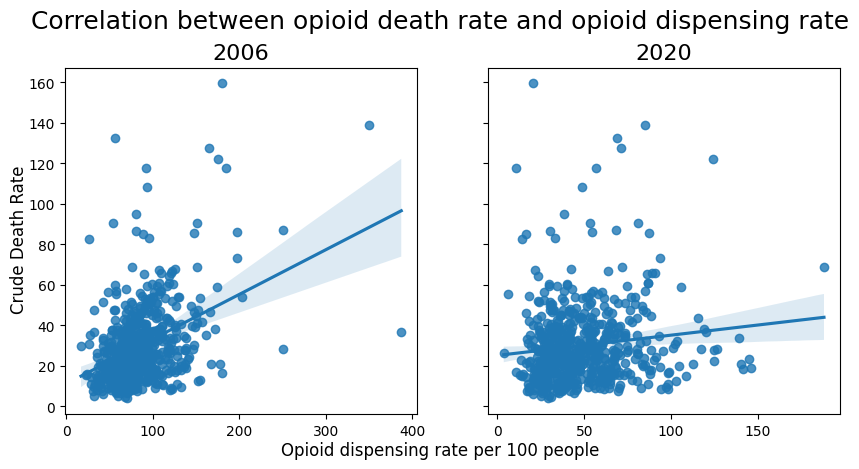

In [121]:
fig, ax = plt.subplots(1, 2, sharey = True, figsize=(10, 4.5))

sns.regplot(data=prescription_death_2006, x="Opioid Dispensing Rate per 100", y="Crude Rate", ax=ax[0])
sns.regplot(data=prescription_death, x="Opioid Dispensing Rate per 100", y="Crude Rate", ax=ax[1])
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].set_title("2006", size=16)
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_title("2020", size=16)
fig.suptitle("Correlation between opioid death rate and opioid dispensing rate", size=18, y=1.01)
fig.supxlabel("Opioid dispensing rate per 100 people", y = 0.01)
fig.supylabel("Crude Death Rate", x = 0.07)

## Question 4

In [124]:
# Q5 Statistical tests
g1 = prescription_death["Deaths"][prescription_death["ru_continuum"] == "Urban"]
g2 = prescription_death["Deaths"][prescription_death["ru_continuum"] == "Rural"]


pd.DataFrame(
    {
        "Shapiro-Wilk's test of normality": stats.shapiro(prescription_death["Deaths"]),
        "Shapiro-Wilk's test of normality (Urban)": stats.shapiro(g1),
        "Shapiro-Wilk's test of normality (Rural)": stats.shapiro(g2),
        "Levene's test of homoscedasticity": stats.levene(g1, g2),
    },
    index=['Test Statistics', 'p-value']
).T

,Test Statistics,p-value
Shapiro-Wilk's test of normality,0.513096,2.810572e-37
Shapiro-Wilk's test of normality (Urban),0.533053,4.915756e-35
Shapiro-Wilk's test of normality (Rural),0.735969,2.566978e-09
Levene's test of homoscedasticity,12.545833,4.286233e-04


In [127]:
sm.stats.anova_oneway(
    data=prescription_death["Deaths"],
    groups=prescription_death["ru_continuum"],
    use_var="unequal",
)

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 119.91752062040705
pvalue = 1.7333177596467566e-25
df = (1.0, 577.6192673314)
df_num = 1.0
df_denom = 577.6192673314
nobs_t = 589.0
n_groups = 2
means = array([ 31.80952381, 108.65969582])
nobs = array([ 63., 526.])
vars_ = array([  206.18894009, 24184.03444867])
use_var = 'unequal'
welch_correction = True
tuple = (119.91752062040705, 1.7333177596467566e-25)

## Multiple regression

In [130]:
sdoh_reg = prescription_death[['Crude Rate', 'AMFAR_MEDSAFAC_RATE', 'AMFAR_MEDMHFAC_RATE', 'SAIPE_MEDIAN_HH_INCOME', 'ACS_GINI_INDEX', 'SAIPE_PCT_POV']]
pipe = ColumnTransformer((
    ('ss', StandardScaler(), sdoh_reg.columns),
))

sdoh_reg = pd.DataFrame(pipe.fit_transform(sdoh_reg), columns=pipe.named_transformers_.ss.get_feature_names_out())
sdoh_reg = pd.concat([sdoh_reg, prescription_death['ru_continuum']], axis=1)

smf.ols(formula="Q('Crude Rate') ~ + Q('AMFAR_MEDSAFAC_RATE') + Q('AMFAR_MEDMHFAC_RATE') + Q('SAIPE_MEDIAN_HH_INCOME') + Q('ACS_GINI_INDEX') + Q('SAIPE_PCT_POV') + C(ru_continuum)", data = sdoh_reg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Crude Rate')   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     34.61
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           8.29e-36
Time:                        03:42:39   Log-Likelihood:                -745.90
No. Observations:                 589   AIC:                             1506.
Df Residuals:                     582   BIC:                             1536.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.4137      0.116      3.566      0.000       0.186       0.642
C(ru_continuum)[T.Urban]       -0.4633      0.124     -3.746      0.000      -0.706      -0.220
Q('AMFAR_MEDSAFAC_RATE')        0.1781      0.046      3.885      0.000       0.088       0.268
Q('AMFAR_MEDMHFAC_RATE')        0.0981      0.045      2.157      0.031       0.009       0.187
Q('SAIPE_MEDIAN_HH_INCOME')    -0.0663      0.060     -1.096      0.274      -0.185       0.053
Q('ACS_GINI_INDEX')            -0.0449      0.043     -1.040      0.299      -0.130       0.040
Q('SAIPE_PCT_POV')              0.2708      0.067      4.034      0.000       0.139       0.403
==============================================================================
Omnibus:                      221.469   Durbin-Watson:                   1.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1015.303
Skew:                           1.647   Prob(JB):                    3.39e-221
Kurtosis:                       8.524   Cond. No.                         7.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""